# Cubed Demo

Cubed implements the [Python Array API standard](https://data-apis.org/array-api/latest/) - or currently a small subset - so a simple way to create an array for demonstration purposes is using `asarray`:

In [1]:
import cubed
import cubed.array_api as xp
a = xp.asarray([[1, 2, 3], [4, 5, 6], [7, 8, 9]], chunks=(2, 2))

Notice that we specify chunks, just like in Dask Array.

Let's create another array and then add them together.

In [2]:
b = xp.asarray([[1, 1, 1], [1, 1, 1], [1, 1, 1]], chunks=(2, 2))
c = xp.add(a, b)
c

Array<array-003, shape=(3, 3), dtype=int64, chunks=((2, 1), (2, 1))>

Cubed uses lazy evaluation, so nothing has been computed yet. We call `compute()` to run the computation and get the result as a NumPy array. (Again, just like in Dask.)

In [3]:
c.compute()

array([[ 2,  3,  4],
       [ 5,  6,  7],
       [ 8,  9, 10]])

## Storage

Every array in Cubed is backed by a Zarr array. The arrays `a`, `b`, and `c` above are all written to a temporary directory on the filesystem. Let's set the working directory explicitly so we can inspect it later. We do this by creating a `Spec` object.

In [4]:
spec = cubed.Spec(work_dir="tmp", max_mem=100_000)

We've also set the maximum memory to 100KB, which is plenty for these small arrays - we'll come back to that later.

Now let's run the example again, passing in the spec when we create the arrays:

In [5]:
a = xp.asarray([[1, 2, 3], [4, 5, 6], [7, 8, 9]], chunks=(2, 2), spec=spec)
b = xp.asarray([[1, 1, 1], [1, 1, 1], [1, 1, 1]], chunks=(2, 2), spec=spec)
c = xp.add(a, b)

If we look at what's in the work directory, we see that there are three Zarr arrays.

In [6]:
! find tmp | sort

tmp
tmp/context-20220628T125138-98eeab38-4d55-4bb8-bfc7-3a7129d7aeb9
tmp/context-20220628T125138-98eeab38-4d55-4bb8-bfc7-3a7129d7aeb9/array-004.zarr
tmp/context-20220628T125138-98eeab38-4d55-4bb8-bfc7-3a7129d7aeb9/array-004.zarr/.zarray
tmp/context-20220628T125138-98eeab38-4d55-4bb8-bfc7-3a7129d7aeb9/array-004.zarr/0.0
tmp/context-20220628T125138-98eeab38-4d55-4bb8-bfc7-3a7129d7aeb9/array-004.zarr/0.1
tmp/context-20220628T125138-98eeab38-4d55-4bb8-bfc7-3a7129d7aeb9/array-004.zarr/1.0
tmp/context-20220628T125138-98eeab38-4d55-4bb8-bfc7-3a7129d7aeb9/array-004.zarr/1.1
tmp/context-20220628T125138-98eeab38-4d55-4bb8-bfc7-3a7129d7aeb9/array-005.zarr
tmp/context-20220628T125138-98eeab38-4d55-4bb8-bfc7-3a7129d7aeb9/array-005.zarr/.zarray
tmp/context-20220628T125138-98eeab38-4d55-4bb8-bfc7-3a7129d7aeb9/array-005.zarr/0.0
tmp/context-20220628T125138-98eeab38-4d55-4bb8-bfc7-3a7129d7aeb9/array-005.zarr/0.1
tmp/context-20220628T125138-98eeab38-4d55-4bb8-bfc7-3a7129d7aeb9/array-005.zarr/1.0
tmp/con

Two Zarr arrays, corresponding to `a` and `b`, are populated with data even though we haven't run the calculation yet. This is because `asarray` writes the data to Zarr immediately.

The third array, corresponding to `c`, only has Zarr metadata present (the `.zarray` file).

When we call `compute()` we get the result back:

In [7]:
c.compute()

array([[ 2,  3,  4],
       [ 5,  6,  7],
       [ 8,  9, 10]])

And the resulting Zarr array, `c`, is now stored on the filesystem:

In [8]:
! find tmp | sort

tmp
tmp/context-20220628T125138-98eeab38-4d55-4bb8-bfc7-3a7129d7aeb9
tmp/context-20220628T125138-98eeab38-4d55-4bb8-bfc7-3a7129d7aeb9/array-004.zarr
tmp/context-20220628T125138-98eeab38-4d55-4bb8-bfc7-3a7129d7aeb9/array-004.zarr/.zarray
tmp/context-20220628T125138-98eeab38-4d55-4bb8-bfc7-3a7129d7aeb9/array-004.zarr/0.0
tmp/context-20220628T125138-98eeab38-4d55-4bb8-bfc7-3a7129d7aeb9/array-004.zarr/0.1
tmp/context-20220628T125138-98eeab38-4d55-4bb8-bfc7-3a7129d7aeb9/array-004.zarr/1.0
tmp/context-20220628T125138-98eeab38-4d55-4bb8-bfc7-3a7129d7aeb9/array-004.zarr/1.1
tmp/context-20220628T125138-98eeab38-4d55-4bb8-bfc7-3a7129d7aeb9/array-005.zarr
tmp/context-20220628T125138-98eeab38-4d55-4bb8-bfc7-3a7129d7aeb9/array-005.zarr/.zarray
tmp/context-20220628T125138-98eeab38-4d55-4bb8-bfc7-3a7129d7aeb9/array-005.zarr/0.0
tmp/context-20220628T125138-98eeab38-4d55-4bb8-bfc7-3a7129d7aeb9/array-005.zarr/0.1
tmp/context-20220628T125138-98eeab38-4d55-4bb8-bfc7-3a7129d7aeb9/array-005.zarr/1.0
tmp/con

We can look at the plan created for the computation by calling `visualize`.

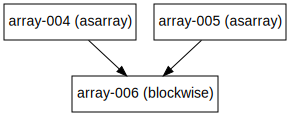

In [9]:
c.visualize("add")

Hover on an array to see its metadata (shape, chunks, and so on), as well as information about how much memory is needed to compute it and the number of tasks.

## Memory

Going back to `max_mem`, Cubed knows the sizes of the input chunks and how much memory will be needed for computing each output chunk. If this exceeds `max_mem` then an exception will be raised immediately (before `compute` is even called).

For example, the arrays we are using are `float64` and so each element takes 8 bytes:

In [10]:
a.dtype.itemsize

8

Since the chunks are of size `(2, 2)`, this means that the amount of memory needed to compute an output chunk is `8 * 4 * 3 = 96`. (The 3 comes from the fact there are two inputs and one output.)

So if we set the maximum memory to 90 we get an error:

In [11]:
spec = cubed.Spec(work_dir="tmp", max_mem=90)
a = xp.asarray([[1, 2, 3], [4, 5, 6], [7, 8, 9]], chunks=(2, 2), spec=spec)
b = xp.asarray([[1, 1, 1], [1, 1, 1], [1, 1, 1]], chunks=(2, 2), spec=spec)
try:
    c = xp.add(a, b)
except ValueError as e:
    print(e)

Blockwise memory (96) exceeds max_mem (90)


## Executors

All the computation so far has run in the current Python process. For larger, more realistic workloads, the computations are spread across multiple machines. Cubed uses Rechunker's execution framework to achieve this, so we can run on Apache Beam for example:

In [12]:
from cubed.runtime.executors.beam import BeamPipelineExecutor
    
spec = cubed.Spec(work_dir="tmp", max_mem=100_000)
a = xp.asarray([[1, 2, 3], [4, 5, 6], [7, 8, 9]], chunks=(2, 2), spec=spec)
b = xp.asarray([[1, 1, 1], [1, 1, 1], [1, 1, 1]], chunks=(2, 2), spec=spec)
c = xp.add(a, b)
c.compute(executor=BeamPipelineExecutor())

array([[ 2,  3,  4],
       [ 5,  6,  7],
       [ 8,  9, 10]])

In this case we still are still running in the local Python process, because Beam is using an in-memory runner itself. However, we can run on Google Cloud, for example, by setting the Beam runner to `DataflowRunner`, and using a Google Cloud Storage work directory (`gs://...`). You can see examples of this in the `examples` directory.

In [13]:
! rm -rf tmp